In [1]:
import pandas as pd
pd.options.display.max_columns=1000
pd.options.display.max_rows=1000

import optuna
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.base import clone

from xgboost import XGBClassifier

In [2]:
train=pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (19219, 35)
The dimension of the test dataset is: (12814, 28)


In [3]:
TARGET = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', \
          'Dirtiness', 'Bumps', 'Other_Faults']

In [4]:
train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [6]:
test.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,19219,1015,1033,3826564,3826588,659,23,46,62357,67,127,1656,0,1,150,0.3877,0.4896,0.3273,0.0095,0.5652,1.0000,1.0,2.8410,1.1139,1.6628,0.6727,-0.2261,0.9172
1,19220,1257,1271,419960,419973,370,26,28,39293,92,132,1354,0,1,40,0.1629,0.4136,0.0938,0.0047,0.2414,1.0000,1.0,2.5682,0.9031,1.4472,0.9063,-0.1453,0.9104
2,19221,1358,1372,117715,117724,289,36,32,29386,101,134,1360,0,1,40,0.0609,0.6234,0.4762,0.0155,0.6000,0.7500,0.0,2.4609,1.3222,1.3222,-0.5238,-0.0435,0.6514
3,19222,158,168,232415,232440,80,10,11,8586,107,140,1690,1,0,100,0.4439,0.3333,0.8182,0.0037,0.8000,1.0000,1.0,1.9031,0.6990,1.0414,0.1818,-0.0738,0.2051
4,19223,559,592,544375,544389,140,19,15,15524,103,134,1688,1,0,60,0.8191,0.2619,0.4286,0.0158,0.8421,0.5333,0.0,2.1461,1.3222,1.1461,-0.5714,-0.0894,0.4170


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12814 entries, 0 to 12813
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     12814 non-null  int64  
 1   X_Minimum              12814 non-null  int64  
 2   X_Maximum              12814 non-null  int64  
 3   Y_Minimum              12814 non-null  int64  
 4   Y_Maximum              12814 non-null  int64  
 5   Pixels_Areas           12814 non-null  int64  
 6   X_Perimeter            12814 non-null  int64  
 7   Y_Perimeter            12814 non-null  int64  
 8   Sum_of_Luminosity      12814 non-null  int64  
 9   Minimum_of_Luminosity  12814 non-null  int64  
 10  Maximum_of_Luminosity  12814 non-null  int64  
 11  Length_of_Conveyer     12814 non-null  int64  
 12  TypeOfSteel_A300       12814 non-null  int64  
 13  TypeOfSteel_A400       12814 non-null  int64  
 14  Steel_Plate_Thickness  12814 non-null  int64  
 15  Ed

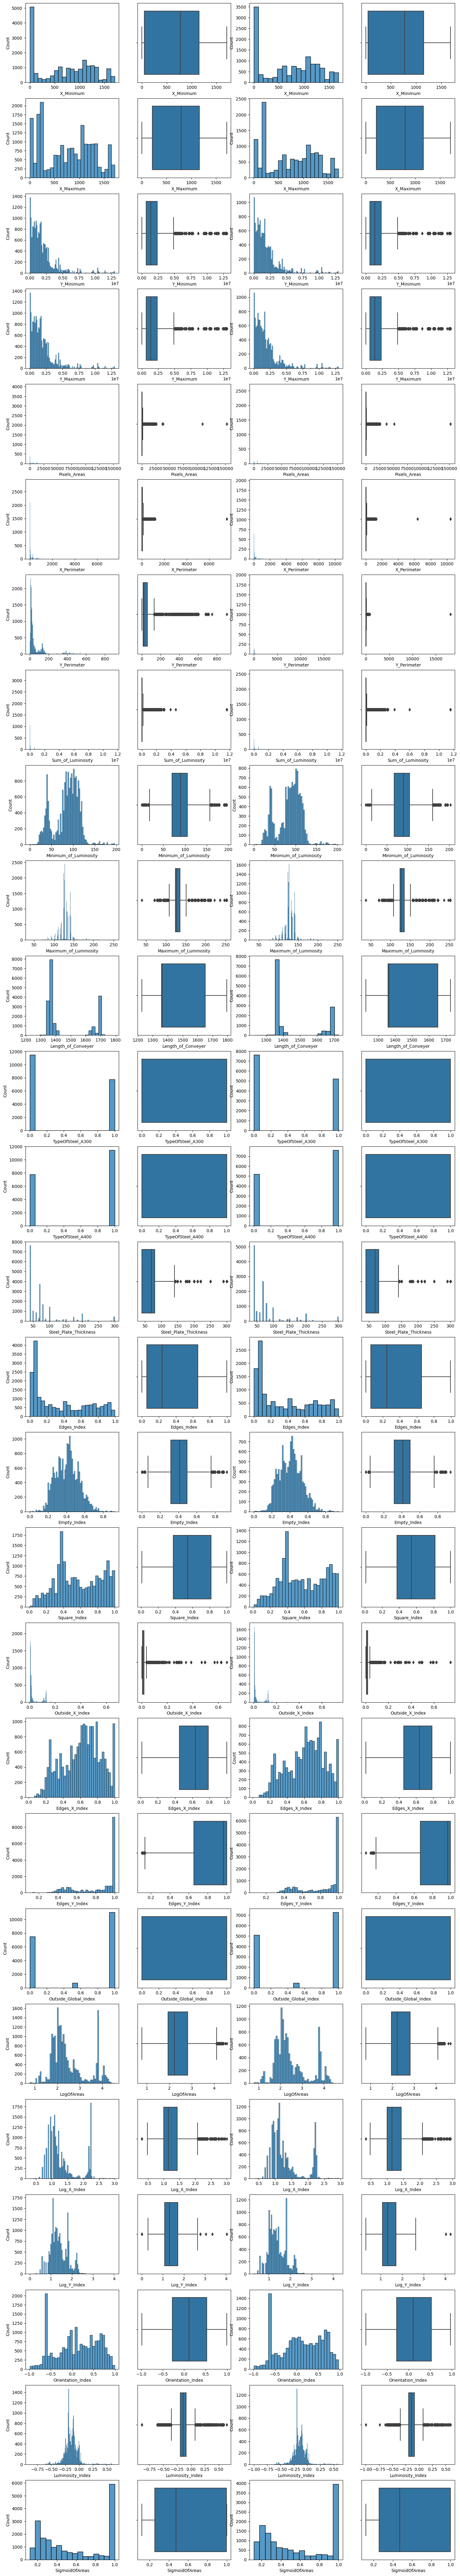

In [9]:
feature_col = test.drop('id', axis=1).columns

plot_col_number = len(feature_col)
fig, axes = plt.subplots(plot_col_number, 4, figsize=(18, plot_col_number*4))


for i, col in enumerate(feature_col):
    sns.histplot(data=train, x=col, ax=axes[i, 0])
    sns.boxplot(data=train, x=col, ax=axes[i, 1])  
    sns.histplot(data=test, x=col, ax=axes[i, 2])
    sns.boxplot(data=test, x=col, ax=axes[i, 3])

# Preprocessing

In [10]:
prep_train = train.copy()
prep_test = test.copy()

In [11]:
def preprocess_data(df):
    data = df.copy()
    
    # Location Features
    data['X_Distance'] = data['X_Maximum'] - data['X_Minimum']
    data['Y_Distance'] = data['Y_Maximum'] - data['Y_Minimum']

    return data

prep_train = preprocess_data(prep_train)
prep_test = preprocess_data(prep_test)

In [12]:
feature_col = prep_test.drop(['id'], axis=1).columns.to_list()

In [13]:
col_transformer  = ColumnTransformer(
        transformers=[('num', StandardScaler(), feature_col)
                     ])

pipe = Pipeline([
    ('preproc', col_transformer)
])

pipe = pipe.fit(prep_test[feature_col])
X = pd.DataFrame(pipe.transform(prep_train[feature_col]), columns=pipe.get_feature_names_out())
X_test = pd.DataFrame(pipe.transform(prep_test[feature_col]), columns=pipe.get_feature_names_out())

y = train[TARGET]

# XGB model

Parameters are selected according to the number of iterations of cross-validation

In [14]:
param15 = {
    'n_estimators': 545, 
    'learning_rate': 0.017102246251565135, 
    'subsample': 0.8852545771159398, 
    'colsample_bytree': 0.46201361760757775, 
    'min_child_weight': 2, 
    'reg_lambda': 4.743332455543137e-06, 
    'reg_alpha': 0.18518708108018359
}

param30 = {
    'n_estimators': 1398, 
    'learning_rate': 0.00034315731093292326, 
    'subsample': 0.544698864772589, 
    'colsample_bytree': 0.41917091462193334, 
    'min_child_weight': 3, 
    'reg_lambda': 0.0001532326475398559, 
    'reg_alpha': 1.3559328689548903e-05
}

param60 = {
    'n_estimators': 909, 
    'learning_rate': 0.005076338331253968, 
    'subsample': 0.8941827889792338, 
    'colsample_bytree': 0.5802049878524871, 
    'min_child_weight': 7, 
    'reg_lambda': 6.580195718248806e-08, 
    'reg_alpha': 0.15744564546370932
}

In [15]:
models = {
    'param15': XGBClassifier(**param15, random_state=42),
    'param30': XGBClassifier(**param30, random_state=42),
    'param60': XGBClassifier(**param60, random_state=42)
}

In [16]:
def cross_val_models(estimators, n_splits=5, verbose=True):
    valid_score = []
    pred_test_list = []
    
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=5)
    all_models = {}
    
    
    for key in estimators:
        models = []
        print(f'Model: {key}')
        for fold, (train_ind, valid_ind) in enumerate(skf.split(X, y[TARGET[0]])):
            model = clone(estimators[key])
            #define train set
            X_train = X.iloc[train_ind]
            y_train = y.iloc[train_ind]
            #define valid set
            X_valid = X.iloc[valid_ind]
            y_valid = y.iloc[valid_ind]        

            model.fit(X_train, y_train)        

            if verbose:
                valid_score.append(roc_auc_score(y_valid, model.predict_proba(X_valid)))

                print(f"Fold: {fold}", end=' ')
                print(f"Train Acc: {roc_auc_score(y_train, model.predict_proba(X_train))}", end=' ')
                print(f"Valid Acc: {valid_score[fold]}")

            models.append(model)
        all_models[key] = models
        print(f'Mean valid score: {np.mean(valid_score)}\n')
            
    return all_models

n_splits = 5
models = cross_val_models(models, n_splits)

Model: param15
Fold: 0 Train Acc: 0.9667656920488561 Valid Acc: 0.8868152302967873
Fold: 1 Train Acc: 0.9659061123063157 Valid Acc: 0.8917996725066005
Fold: 2 Train Acc: 0.9670581885698207 Valid Acc: 0.8890067855879921
Fold: 3 Train Acc: 0.9670044036252164 Valid Acc: 0.8802527069294082
Fold: 4 Train Acc: 0.9667226516163373 Valid Acc: 0.8883306767282502
Mean valid score: 0.8872410144098076

Model: param30
Fold: 0 Train Acc: 0.9116133824453335 Valid Acc: 0.8868152302967873
Fold: 1 Train Acc: 0.9106873678947923 Valid Acc: 0.8917996725066005
Fold: 2 Train Acc: 0.9106899565042947 Valid Acc: 0.8890067855879921
Fold: 3 Train Acc: 0.91295180382343 Valid Acc: 0.8802527069294082
Fold: 4 Train Acc: 0.9114413860479379 Valid Acc: 0.8883306767282502
Mean valid score: 0.8847418562632392

Model: param60
Fold: 0 Train Acc: 0.9343761496552256 Valid Acc: 0.8868152302967873
Fold: 1 Train Acc: 0.9332414697604018 Valid Acc: 0.8917996725066005
Fold: 2 Train Acc: 0.9343808480908959 Valid Acc: 0.88900678558799

Predicting the test dataset for submission

In [17]:
y_pred_all = np.zeros([X_test.shape[0], 7], dtype=np.float32)

for key in models:
    models_fold = models[key]
    y_pred = np.zeros([X_test.shape[0], 7], dtype=np.float32)
    
    for model_fold in models_fold:
        y_pred += model_fold.predict_proba(X_test)
    y_pred /= len(models_fold)
    y_pred_all += y_pred
    
y_pred_all /= len(models)

In [18]:
submission=pd.read_csv('/kaggle/input/playground-series-s4e3/sample_submission.csv')

submission[TARGET] = y_pred_all
submission.to_csv("submission_xgb_all_models.csv",index=False)

# Optuna
Hyper parameter selection with optuna

In [19]:
# %%time

# # Dictionary to store best parameters and ROC AUC scores for each target
# best_params_xgb = {}
# best_auc_scores_xgb = {}

# # Iterate over target columns
# def objective(trial):
#     # Define parameters
#     xgb_params = {
#         'grow_policy': 'depthwise',
#         'n_estimators': trial.suggest_int('n_estimators', 500, 2000), 
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1), 
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1), 
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 25), 
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10),
#         'booster':'gbtree',
#         'verbosity': 0,
#         'device_type': 'cuda',
#         'tree_method': 'gpu_hist'
#     }

#         # Define a model with parameters
#     model = XGBClassifier(**xgb_params, random_state=42)

#        # Calculate ROC AUC on cross-validation
#     auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
#     auc_mean = np.mean(auc_scores)

#     return 1 - auc_mean  # Optuna minimizes the objective, so we use 1 - ROC AUC to maximize it

#    # Optuna optimization loop
# study = optuna.create_study(direction='minimize')  # Invert direction to minimize 1 - ROC AUC
# study.optimize(objective, n_trials=50)

# print(f"Best hyperparameters: {study.best_params}")
# print(f"Best ROC AUC cross-validation: {1 - study.best_value}")